In [1]:
from os import sys
sys.path.append('../')

# Getting packages #
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import savgol_filter
import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
## Pickling that DF for Later ##

#df.to_pickle("../data/june13_2022_100Hz.pkl")

## Unpickling 
df_100Hz = pd.read_pickle("../data/june13_2022_100Hz.pkl")
#df_60Hz = pd.read_pickle("./data/june15_2022_60Hz.pkl")
#df_1Hz = pd.read_pickle("./data/june15_2022_1Hz.pkl")

df = df_100Hz.interpolate(method="linear")

In [3]:
# Vehicle parameters
prop = propellers.aeronaut185x12() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

highorderpolar = True

In [4]:
# Rate of temperature change
# Hardcoded for sample rate of 10 ms data frequency

df.Ambient_Temperature = df.Ambient_Temperature.fillna(-1)
y = savgol_filter(df.Ambient_Temperature.to_numpy(), 5001, 0)

# Adding filtered temperatures to dataframe
s = pd.Series(y, df.index)
print(type(s))
df["Ambient_TemperatureSG"] = s
print(type(df.Ambient_TemperatureSG))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


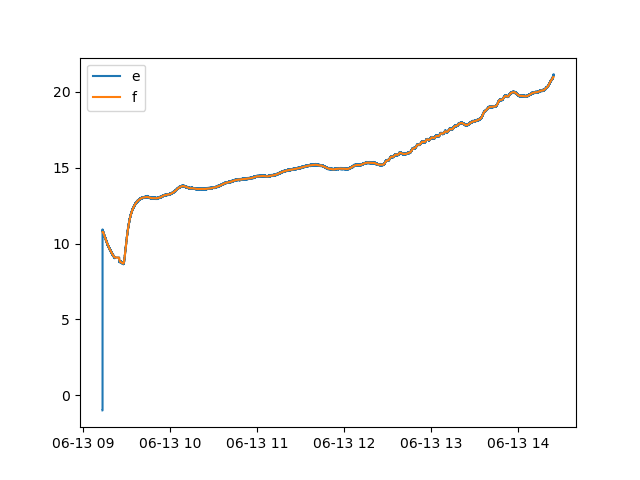

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [5]:

plt.figure()
plt.plot(df.Ambient_Temperature, label='e')
plt.plot(df.Ambient_TemperatureSG, label='f')
plt.legend()
plt.show()

print(type(df.Ambient_Temperature))
print(type(df.Ambient_TemperatureSG))


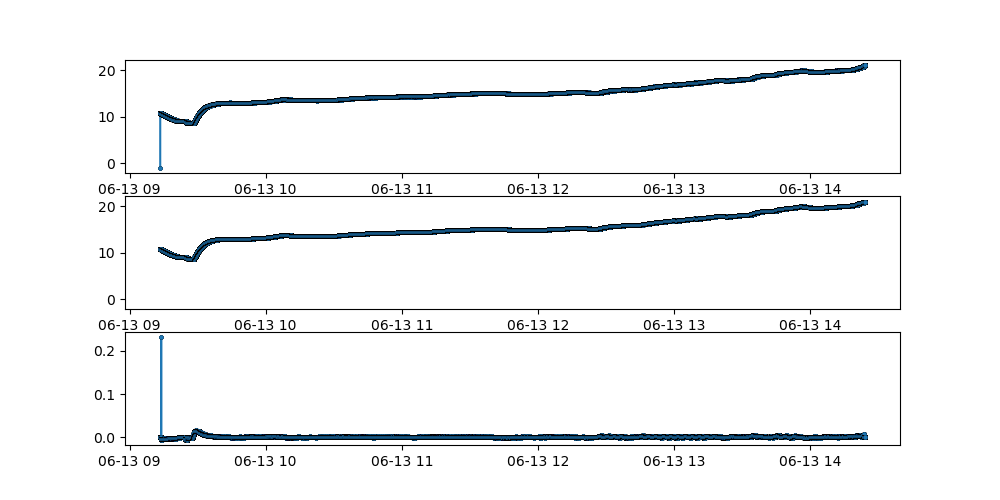

In [6]:

#y = np.linspace(0,100,1000)
#y = y + np.random.normal(0,1,1000)

df["TemperatureRate"] = df.Ambient_TemperatureSG.diff() / (10/1000)

#df.Ambient_TemperatureSG = df.Ambient_Temperature.transform(lambda x: savgol_filter(x, 5, 1))

plt.figure(figsize=(10,5))
ax1 = plt.subplot(3,1,1)
ax1.plot(df.index, df.Ambient_Temperature, label="Ambient Temperature", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)

ax2 = plt.subplot(3,1,2, sharex=ax1, sharey=ax1)
ax2.plot(df.index, df.Ambient_TemperatureSG, label="Filtered Ambient Temperature", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(df.index, df.TemperatureRate, label="Filtered Ambient Temperature Rate", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
plt.show()



# Filtering the rate because data is way oversampled

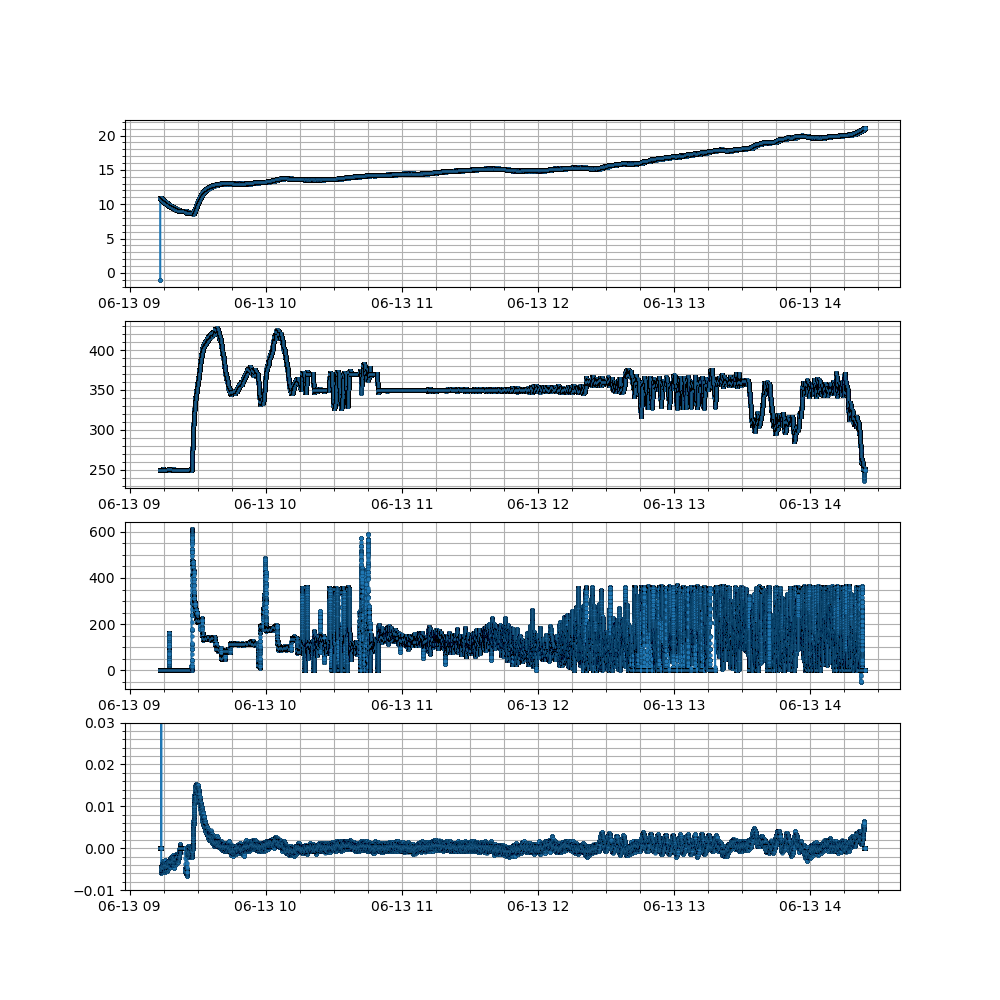

In [7]:
## Plotting the ARSP Temperature

plt.figure(figsize=(10,10))
plt.title("Full Flight Data")

plt.minorticks_on()

ax1 = plt.subplot(4,1,1)
ax1.plot(df.index, df.Ambient_Temperature, label="Airspeed Temperature", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
ax1.grid(which='minor')
ax1.grid(which='major')
ax1.minorticks_on()

ax2 = plt.subplot(4,1,2, sharex=ax1)
ax2.plot(df.index, df.Altitude, label="Altitude", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
ax2.grid(which='minor')
ax2.grid(which='major')
ax2.minorticks_on()

ax3 = plt.subplot(4,1,3, sharex=ax2)
ax3.plot(df.index, df.EscCurrent * df.EscVoltage, label="Motor power", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
ax3.grid(which='minor')
ax3.grid(which='major')
ax3.minorticks_on()

ax4 = plt.subplot(4,1,4, sharex=ax2)
ax4.plot(df.index, df.TemperatureRate, label=" Rate of Temp Change", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
ax4.set_ylim([-0.01, 0.03])
ax4.grid(which='minor')
ax4.grid(which='major')
ax4.minorticks_on()
plt.show()

## Conclusions from the Plots above:

1. There doesn't seem to be a correlation between when the motor turns on, and when the temperature changes
2. Temperature changes are correlated with changes in altitude

https://www.weather.gov/source/zhu/ZHU_Training_Page/winds/nighttime_influences/Nighttime_Influences.htm#:~:text=A%20nocturnal%20temperature%20inversion%2C%20marked,cooling%20ground%20cools%20through%20conduction.